In [69]:
import os
import numpy as np
import keras
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
#from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
#from keras.optimizers import RMSprop
import functools
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from keras.layers import Conv2D, MaxPooling2D
#from keras.optimizers import RMSprop,Adam
from keras.callbacks import LearningRateScheduler
import math
from tensorflow.keras.optimizers import RMSprop,Adam

In [70]:
IMG_ROWS, IMG_COLS = 224, 224
INPUT_SHAPE=(224, 224, 3)
PATH = 'Data/processed_data/'
TRAIN_DATA_PATH = os.path.join(PATH, 'Training')
TEST_DATA_PATH = os.path.join(PATH, 'Testing')
BATCH_SIZE = 64
NUM_EPOCHS = 100
CLASS_MODE = 'categorical'
COLOR_MODE = 'rgb'
SAVE_FORMAT = 'png'


In [71]:
data_dir_list =np.sort(os.listdir(TRAIN_DATA_PATH))
data_dir_list

array(['normal', 'pneumonia'], dtype='<U9')

In [72]:
data_dir_list_Test =np.sort(os.listdir(TEST_DATA_PATH))
data_dir_list_Test

array(['normal', 'pneumonia'], dtype='<U9')

In [73]:
train_data_gen = ImageDataGenerator(
    rotation_range=50,
    brightness_range=[0.2,0.8],
    vertical_flip=True, 
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[0.5,0.8],
    rescale=1./255,
    validation_split=0.2) 

In [74]:
train_generator = train_data_gen.flow_from_directory(
        TRAIN_DATA_PATH,
        target_size=(IMG_ROWS, IMG_COLS), 
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        color_mode=COLOR_MODE, 
        shuffle=True,   
        save_format=SAVE_FORMAT, 
        subset="training")


val_generator = train_data_gen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=(IMG_ROWS, IMG_COLS), 
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    shuffle=True,   
    save_format=SAVE_FORMAT, 
    subset='validation'
)

Found 3017 images belonging to 2 classes.
Found 754 images belonging to 2 classes.


In [75]:
train_generator.samples 

3017

In [76]:
train_generator.class_indices

{'normal': 0, 'pneumonia': 1}

In [77]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    shuffle = False,
    seed=None,  
    save_format=SAVE_FORMAT
)


Found 541 images belonging to 2 classes.


In [78]:
def create_nasnet_model():
    
    # Base model, with weights pre-trained on ImageNet.
    base_model = NASNetMobile(INPUT_SHAPE, weights='imagenet', include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    
    learning_rate = 0.1
    momentum = 0.8
    optimizer = tf.keras.optimizers.SGD(lr=learning_rate, momentum=momentum, nesterov=False)

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizer,
        metrics = ['accuracy']
    )
    
    return model

In [79]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [80]:
def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

lr_scheduler =keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [81]:
callbacks_list  = [lr_scheduler]

In [82]:
model = create_nasnet_model()

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=NUM_EPOCHS,
    workers=6,
    max_queue_size=100,
    verbose=True,
    callbacks=callbacks_list
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
48/48 [==============================] - 138s 2s/step - loss: 1.4436 - accuracy: 0.7123 - val_loss: 0.5274 - val_accuracy: 0.8302
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
48/48 [==============================] - 90s 2s/step - loss: 1.0780 - accuracy: 0.7560 - val_loss: 0.6196 - val_accuracy: 0.8249
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
48/48 [==============================] - 90s 2s/step - loss: 1.2290 - accuracy: 0.7494 - val_loss: 0.6816 - val_accuracy: 0.8249
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
48/48 [==============================] - 90s 2s/step - loss: 1.0381 - accuracy: 0.7720 - val_loss: 0.5531 - val_accuracy: 0.8369
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.1.
48/48 [==============================] - 90s 2s/step - loss: 1.0010 - accuracy: 0.7879 - val_

In [83]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1056)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1056)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2114      
Total params: 4,271,830
Trainable params: 2,114
Non-trainable params: 4,269,716
_________________________________________________________________


In [84]:
loss, accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {accuracy * 100}%")

9/9 [==============================] - 20s 2s/step - loss: 0.3664 - accuracy: 0.8244
Test Accuracy: 82.43992328643799%


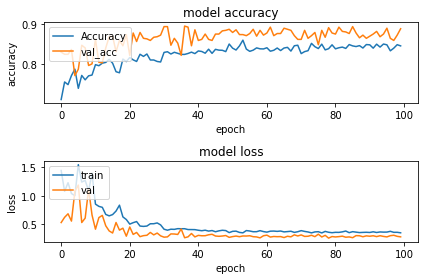

In [85]:

plt.figure(1)

# summarize history for accuracy
plt.subplot(211) 
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'val_acc'], loc='upper left')

# summarize history for loss
plt.subplot(212) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout() 
plt.savefig('acc_loss.pdf')
plt.show()